# Behavioral Cloning
processing flow:
1. data preprocessing
2. data augmented
3. building model
4. training phase
5. testing phase

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
import os

### Configuration

In [2]:
w, h, c = 200, 66, 3
config = {
    'input_width': w,
    'input_height': h,
    'input_channels': c,
    'batch_size': 512,
    'delta_correction': 0.1,
    'crop_height': range(20, 140),
    'augmentation_steer_sigma': 0.2,
    'augmentation_value_min': 0.2,
    'augmentation_value_max': 1.5,
    'bias': 0.8,
    'max_speed': 30
}

### dataset loaded
Let's parse the annotations and return dataframe width columns including `['front', 'left', 'right', 'steer', 'throttle', 'brake', 'speed']`, and replacing image path with specific path.

In [3]:
def load_dataset_df(dpath):
    head_csv = ['front', 'left', 'right', 'steer', 'throttle', 'brake', 'speed']
    csv_df = pd.read_csv(os.path.join(dpath, 'driving_log.csv'), names=head_csv)
    csv_df['front'] = [os.path.join(dpath, 'IMG', front.split('\\')[-1]) for front in csv_df['front']]
    csv_df['left'] = [os.path.join(dpath, 'IMG', front.split('\\')[-1]) for front in csv_df['left']]
    csv_df['right'] = [os.path.join(dpath, 'IMG', front.split('\\')[-1]) for front in csv_df['right']]
    return csv_df

dpath = os.path.join('data')
ddf = load_dataset_df(dpath)

Let us see the distribution of steering data in each of direction of camera.

In [4]:
def draw_histogram_of_steering_angle(ddf, save=True, filename='steering_angle.jpg'):
    f, ax = plt.subplots(1, 1)
    ax.set_title('Steering Angle Distribution in Fronted Camera')
    fhist = ax.hist(ddf['steer'].values, 100, density=False, facecolor='green', alpha=0.7, width=0.03)
    ax.set_ylabel('frames')
    ax.set_xlabel('steering angle')
    # image saved
    if save:
        if not os.path.exists('output'):
            os.makedirs('output')
        plt.savefig(os.path.join('output', filename))
    plt.show()

In [5]:
import random

def moderate_dataset(ddf):
    count, divs = np.histogram(ddf['steer'], bins=100)
    idx = count.argsort()[::-1][:2]

    f_c = count[idx[0]]
    s_c = count[idx[1]]
    f_v = divs[idx[0]]

    drop_idx = ddf['steer'] == f_v
    drop_idx = ddf['steer'][drop_idx].index
    drop_idx = random.sample(drop_idx, f_c - s_c)
    ddf = ddf.drop(drop_idx)
    return ddf

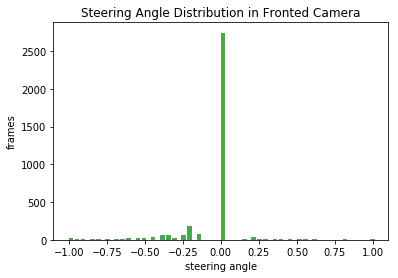

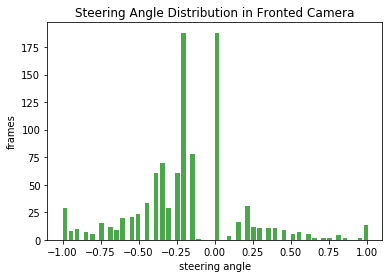

In [6]:
# before mitigate
draw_histogram_of_steering_angle(ddf)
# after
ddf = moderate_dataset(ddf)
draw_histogram_of_steering_angle(ddf, True, filename='steering_angle_m.jpg')

### 1. Data Preprocessing
Choosing randomly among front, left and right mounted camera, each of frames will through several step processed including cropped, color brightness, and flipped.

First at first, transform pandas dataframe into numpy array for future usage.

In [7]:
"""
Transform Pandas dataframe to numpy.matrix so called numpy.array.
Args:
  ddf: pandas dataframe
Return:
  numpy.array
"""
def pd2np(ddf):
    imgs = []
    labels = []
    
    for id, df in ddf.iterrows():
        imgs.append([df['front'],
                     df['left'],
                     df['right']])

        labels.append([float(df['steer']),
                    df['throttle'],
                    df['brake'],
                    float(df['speed'])])
    imgs = np.array(imgs)
    labels = np.array(labels, dtype=np.float32)
    
    return imgs, labels

imgs, labels = pd2np(ddf)

Secondly, lets split data into training and testing set

In [8]:
from sklearn.utils import shuffle

"""
Split dataset into training and testing set according to specific ratio rate.
Args:
  data: dataset
  ratio: ratio rate for training part.
Return:
  train and test dataset
"""
def split_train_test(imgs, labels, ratio=0.8):
    # shuffle
    _imgs, _labels = shuffle(imgs, labels)
    size = int(_labels.shape[0]*ratio)
    train = (_imgs[:size], _labels[:size])
    test = (_imgs[size:], _labels[size:])
    return train, test

train, test = split_train_test(imgs, labels)

Thirdly, cropping and resizing frame.

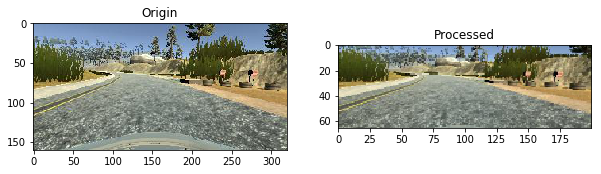

In [9]:
"""
Data preprocessing including cropped and resized.
Args:
  img: path of image or image array only if train is True
  train: default is False.
  verbose: verbose if True
  save: saving image if True
Return:
  processed data
"""
def preprocessing_data(img, train=False, verbose=False, save=False):
    if train:
        img = mpimg.imread(img)
    cropped = img[config['crop_height'], :, :]
    resized = cv2.resize(cropped, dsize=(w, h))
    # if input_channel equals to 1, changed color space from RGB to YUV
    if config['input_channels'] == 1:
        resized = np.expand_dims(cv2.cvtColor(resized, cv2.COLOR_RGB2YUV)[:, :, 0], 2)
    
    if verbose:
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].set_title('Origin')
        ax[0].imshow(img)
        ax[1].set_title('Processed')
        ax[1].imshow(resized)
        if save:
            if not os.path.exists('output'):
                os.makedirs('output')
            plt.savefig(os.path.join('output', 'preprocessing.jpg'))
        plt.show()
        
    return resized.astype(np.float32)

_ = preprocessing_data(train[0][0][0], train=True, verbose=True)

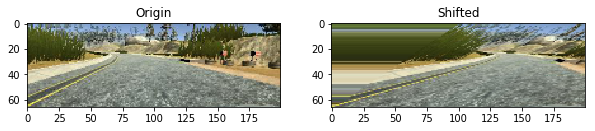

In [10]:
"""
Shifting frame
positive means right, however negative means left
Args:
  frame: input frame
  cam_shift: shift distance
Return:
  np.array
"""
def augmentShift(frame, cam_shift, verbose=False, save=False):
    rows, cols, _ = frame.shape
    shifted_point = [cols / 2 + cam_shift, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], shifted_point])
    M = cv2.getAffineTransform(pts1, pts2)
    _frame = np.copy(frame)
    _frame = cv2.warpAffine(_frame, M, (cols, rows), borderMode=cv2.BORDER_REPLICATE)
    if verbose:
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].set_title('Origin')
        ax[0].imshow(np.uint8(frame))
        ax[1].set_title('Shifted')
        ax[1].imshow(np.uint8(_frame))
        if save:
            if not os.path.exists('output'):
                os.makedirs('output')
            plt.savefig(os.path.join('output', 'shift.jpg'))
        plt.show()
    return _frame

_ = preprocessing_data(train[0][0][1], train=True, verbose=False)
_ = augmentShift(_, 50, True, True)

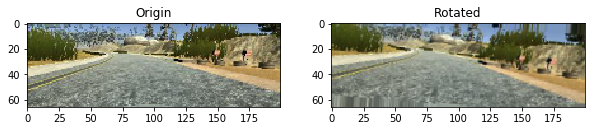

In [11]:
"""
Rotate frame

Args:
  frame: input frame
  cam_degree: degree of rotation
Args:
  np.array
"""
def augmentRotate(frame, cam_degree, verbose=False, save=False):
    rows, cols, _ = frame.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), cam_degree, 1.0)
    _frame = cv2.warpAffine(frame, M, (cols, rows), borderMode=cv2.BORDER_REPLICATE)
    if verbose:
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].set_title('Origin')
        ax[0].imshow(np.uint8(frame))
        ax[1].set_title('Rotated')
        ax[1].imshow(np.uint8(_frame))
        if save:
            if not os.path.exists('output'):
                os.makedirs('output')
            plt.savefig(os.path.join('output', 'rotated.jpg'))
        plt.show()
    return _frame

_ = preprocessing_data(train[0][0][0], train=True, verbose=False)
_ = augmentRotate(_, -5.0, True, False)

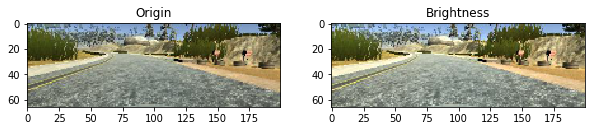

In [12]:
def augmentBrightness(frame, jiter_mask, verbose=False, save=False):
    _frame = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    _frame[:, :, 2] *= jiter_mask
    _frame[:, :, 2] = np.clip(_frame[:, :, 2], a_min=0, a_max=255)
    _frame = cv2.cvtColor(_frame, cv2.COLOR_HSV2RGB)
    if verbose:
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].set_title('Origin')
        ax[0].imshow(np.uint8(frame))
        ax[1].set_title('Brightness')
        ax[1].imshow(np.uint8(_frame))
        if save:
            if not os.path.exists('output'):
                os.makedirs('output')
            plt.savefig(os.path.join('output', 'brightness.jpg'))
        plt.show()
    return _frame

_ = preprocessing_data(train[0][0][0], train=True, verbose=False)
_ = augmentBrightness(_, random.uniform(config['augmentation_value_min'], config['augmentation_value_max']), verbose=True, save=True)

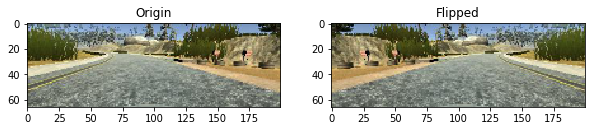

In [13]:
import random

def augmentHorizontalFlipped(frame, verbose=False, save=False):
    _frame = frame[:, ::-1, :]
    if verbose:
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].set_title('Origin')
        ax[0].imshow(np.uint8(frame))
        ax[1].set_title('Flipped')
        ax[1].imshow(np.uint8(_frame))
        if save:
            if not os.path.exists('output'):
                os.makedirs('output')
            plt.savefig(os.path.join('output', 'flipped.jpg'))
        plt.show()
    return _frame

_ = preprocessing_data(train[0][0][0], train=True, verbose=False)
_ = augmentHorizontalFlipped(_, verbose=True, save=True)

Finally, we generate batch of training data augmentated.

In [14]:
"""
Need to augment data or not
Args:
  enable: use normal dist as threshold for condition to choose it;
  On the otherhand allways return False
"""
def needAugmented(enable):
    return np.random.uniform() > 0.5 if enable else False

In [15]:
import random

"""
Generate a batch of data.
Args:
  data: data for generating
  batch_size: size of batching
  augmented: Data augmentation if True
  bias: bias for checking steering angles condition
Return:
  training/testing dataset
"""
def generate_batch(data, batch_size=128, augmented=True, bias=0.5):
    while True:
        imgs, labels = data
        imgs, labels = shuffle(imgs, labels)
        n_current = 0
        X = np.zeros(shape=(batch_size, h, w, c), dtype=np.float32)
        y_steer = np.zeros(shape=(batch_size,), dtype=np.float32)
        y_speed = np.zeros(shape=(batch_size,), dtype=np.float32)
        for idx in range(labels.shape[0]):
            img = np.copy(imgs[idx])
            label = np.copy(labels[idx])
            # choose frame randomly among (front, left, right)
            cameraid = random.randint(0, 2)
            frame = preprocessing_data(img[cameraid], train=True)
            if cameraid == 0:
                steer = label[0]
            elif cameraid == 1:
                steer = label[0] + config['delta_correction']
            else:
                steer = label[0] - config['delta_correction']
            # max speed 
            speed = np.clip((((config['max_speed']/2)-label[-1])/(config['max_speed']/2))-1, a_min=-1.0, a_max=1.0)
            
            if augmented:
                # camera shifting or rotating
                if needAugmented(augmented):
                    cam_shift = np.random.uniform(-100, 100)
                    frame = augmentShift(frame, cam_shift)
                    steer = steer + (cam_shift/(frame.shape[0]/2) * 180/(np.pi*25.0)/6.0)
                else:
                    cam_degree = np.random.uniform(-10, 10)
                    frame = augmentRotate(frame, cam_degree)
                    steer = steer - np.sin(cam_degree*np.pi/180)
                # horizontal flipping
                if random.choice([True, False]):
                    frame = augmentHorizontalFlipped(frame)
                    steer *= -1.
                # perturb slightly steering angle
                steer += np.random.normal(loc=0, scale=config['augmentation_steer_sigma'])
                # if colorful image randomly change brightness
                if config['input_channels'] == 3:
                    jiter_mask = random.uniform(config['augmentation_value_min'], config['augmentation_value_max'])
                    frame = augmentBrightness(frame, jiter_mask, verbose=False, save=False)
            # whether steer angle matchs the condition
            steer_magnitude_thresh = np.random.rand()
            if ((abs(steer) + bias) < steer_magnitude_thresh) or (steer < -1. and steer > 1.):
                pass
            else:
                X[n_current] = frame
                y_steer[n_current] = steer
                y_speed[n_current] = speed 
                n_current += 1
            if n_current == batch_size:     
                break
        yield X, zip(y_steer,y_speed)

### Build Model

In [16]:
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Dropout, Flatten, ELU, Lambda, Dense

def E2EModel(verbose=False):
    inputs = Input(shape=(h, w, c))
    # standardize input that applied here is to be accelerated via GPU processing.
    _ = Lambda(lambda z: z/127.5 - 1.)(inputs)
    
    _ = Conv2D(24, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='elu')(_)
    _ = Conv2D(36, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='elu')(_)
    _ = Conv2D(48, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='elu')(_)
    _ = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='elu')(_)
    _ = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='elu')(_)

    _ = Flatten()(_)
    _ = Dense(100, activation='elu')(_)
    _ = Dense(50, activation='elu')(_)
    _ = Dense(10, activation='elu')(_)
    
    outputs = Dense(2, activation='tanh')(_)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    if verbose:
        model.summary()
        
    return model

Using TensorFlow backend.


In [17]:
model = E2EModel()

### Training

In [ ]:
from keras.callbacks import ModelCheckpoint, CSVLogger
import keras.backend as K
from keras.optimizers import Adam

epochs = 500
steps_per_epoch = config['batch_size']
validation_steps = config['batch_size']
lr = 1e-3

optimizer = Adam(lr=lr)
model.compile(loss='mse', optimizer=optimizer)

if not os.path.exists('weights'):
    os.makedirs('weights')
checkpoint_callback = ModelCheckpoint(os.path.join('weights', 'ep_{epoch:02d}-loss_{val_loss:.5f}.pickle'))
logger = CSVLogger(filename='history.csv')

model.fit_generator(generator=generate_batch(train, batch_size=config['batch_size'], bias=config['bias']),
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs,
                    validation_data=generate_batch(test, batch_size=config['batch_size'], bias=1.0, augmented=False),
                    validation_steps=validation_steps,
                    callbacks=[checkpoint_callback, logger])

In [19]:
from process_data import generate_batch, load_dataset_df, moderate_dataset, pd2np, split_train_test

ddf = load_dataset_df('data')
print("Moderate dataset")
ddf = moderate_dataset(ddf)
print("DataFrame to numpy array")
imgs, labels = pd2np(ddf)
print("Dataset splitted")
train, test = split_train_test(imgs, labels)
g_test = generate_batch(test, batch_size=1, bias=1.0, augmented=False)
x, _ = next(g_test)

Moderate dataset
DataFrame to numpy array
Dataset splitted


In [20]:
from model import E2EModel
model = E2EModel()
model.load_weights('weights/model_ep386.pkl')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
__________

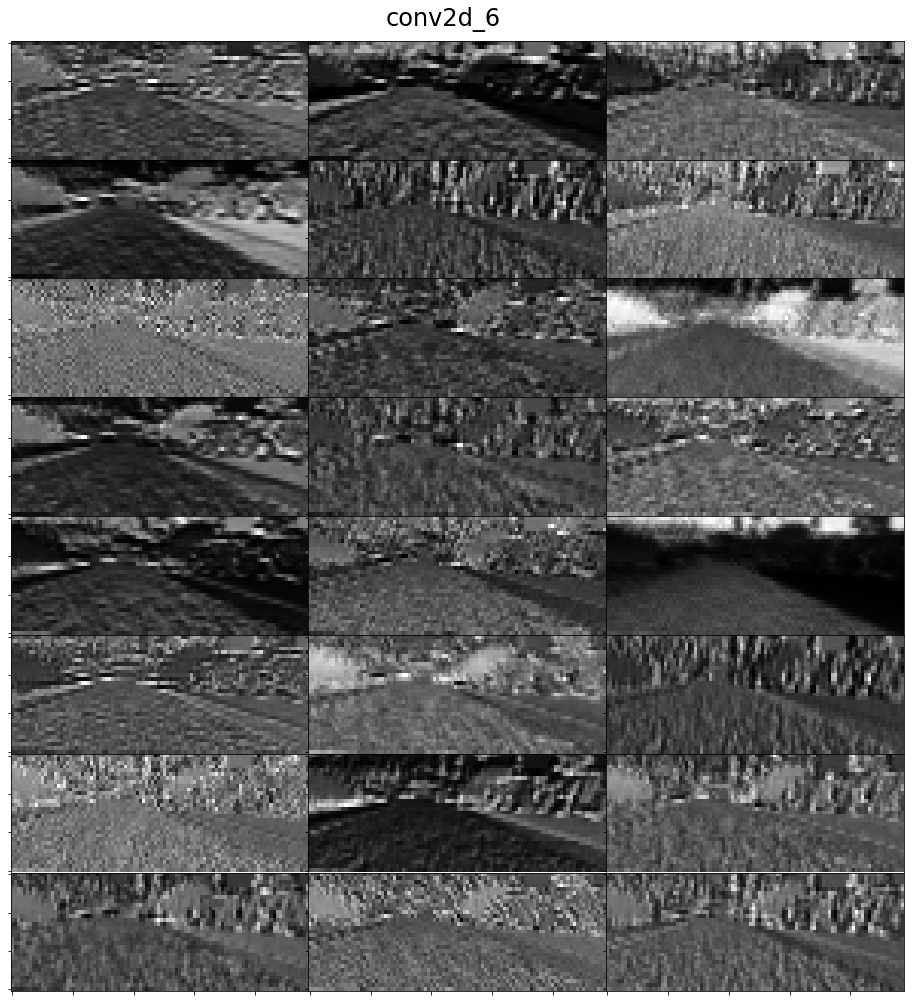

In [23]:
from keras.models import Model
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

layer_name = 'conv2d_6'
_dump = Model(inputs=model.get_layer('input_2').input, outputs=model.get_layer(layer_name).output)
_tmp = _dump.predict(x)
size = np.round(_tmp.shape[-1]/3, 1)
c = 0
fig, ax_array = plt.subplots(size, 3, figsize=(16, 16))
for ax in ax_array.ravel():
    if c >= _tmp.shape[-1]:
        break
    ax.imshow(_tmp[0, :, :, c], cmap='gray')
    ax.set_aspect('auto')
    c+=1
plt.suptitle(layer_name, fontsize=24)
plt.setp([ax.get_xticklabels() for ax in ax_array.ravel()], visible=False)
plt.setp([ax.get_yticklabels() for ax in ax_array.ravel()], visible=False)
plt.subplots_adjust(wspace=0, hspace=0, top=0.95)
plt.savefig(os.path.join('output', layer_name+'.jpg'))
plt.show()

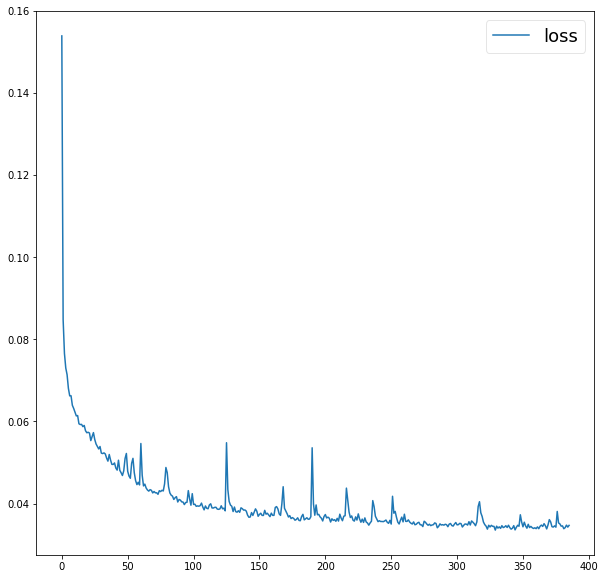

In [68]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

dframe = pd.read_csv('history.csv')
dframe.head()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(dframe['epoch'], dframe['loss'], label='loss')
# ax.plot(dframe['epoch'], dframe['val_loss'], label='loss', color='g')
leg = plt.legend(loc=1, fontsize=18)
leg.get_frame().set_alpha(0.5)
plt.savefig('output/loss.jpg')
plt.show()